# Triangular_fuzzy_number_generate_BPA

## Import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt 

In [2]:
# 1. 加载Iris数据集并划分为训练集和测试集
iris = load_iris()
X = iris.data  # 四个属性
y = iris.target  # 三个类 (0, 1, 2)
num_classes = len(np.unique(iris.target))
num_attributes = iris.data.shape[1]
# 将数据集划分为训练集和测试集，乱序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Get mean and std

In [3]:
# 2. 计算每个类中每个属性的 mean value and standard deviation (无偏估计)

def calculate_mean_std_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1)) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

def calculate_mean_std_min_max_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1), np.min(X_class[:, i]), np.max(X_class[:, i])) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

mean_std_min_max_by_class = calculate_mean_std_min_max_by_class(X_train, y_train, num_classes)
print("每个类中每个属性的均值，标准差，最小值，最大值:\n", mean_std_min_max_by_class)
print("Shape of mean_std_by_class:\n", mean_std_min_max_by_class.shape)

每个类中每个属性的均值，标准差，最小值，最大值:
 [[[5.00487805 0.35982719 4.3        5.8       ]
  [3.43902439 0.40551082 2.3        4.4       ]
  [1.47317073 0.18711546 1.         1.9       ]
  [0.24634146 0.10976694 0.1        0.6       ]]

 [[5.91794872 0.53551343 4.9        7.        ]
  [2.77179487 0.32682582 2.         3.4       ]
  [4.23333333 0.48630364 3.         5.        ]
  [1.31794872 0.20503118 1.         1.8       ]]

 [[6.5825     0.64525388 4.9        7.9       ]
  [2.9925     0.31654181 2.5        3.8       ]
  [5.5375     0.58602857 4.5        6.9       ]
  [2.0125     0.27473764 1.4        2.5       ]]]
Shape of mean_std_by_class:
 (3, 4, 4)


In [4]:
p = 0.4

In [5]:
def get_triangular_membership_functions(mean, std, min_val, max_val, p=0.4):

    u = max_val + p * std  
    l = min_val - p * std  

    def triangular_membership_function(x):
        if x < l:
            return 0  
        elif x > u:
            return 0  
        elif l <= x <= mean:
            return (x - l) / (mean - l)
        elif mean < x <= u:
            return (u - x) / (u - mean)
        else:
            return 0  
    return triangular_membership_function

In [6]:
def get_triangular_membership_functions_list(mean_std_by_class):
    triangular_membership_functions_by_class = []
    for class_data in mean_std_by_class:
        class_functions = []
        for attr_data in class_data:
            mean, std, min_val, max_val = attr_data
            membership_function = get_triangular_membership_functions(mean, std, min_val, max_val)
            class_functions.append(membership_function)
        triangular_membership_functions_by_class.append(class_functions)
    return np.array(triangular_membership_functions_by_class)

triangular_membership_functions_by_class = get_triangular_membership_functions_list(mean_std_min_max_by_class)
triangular_membership_functions_by_class.shape

(3, 4)

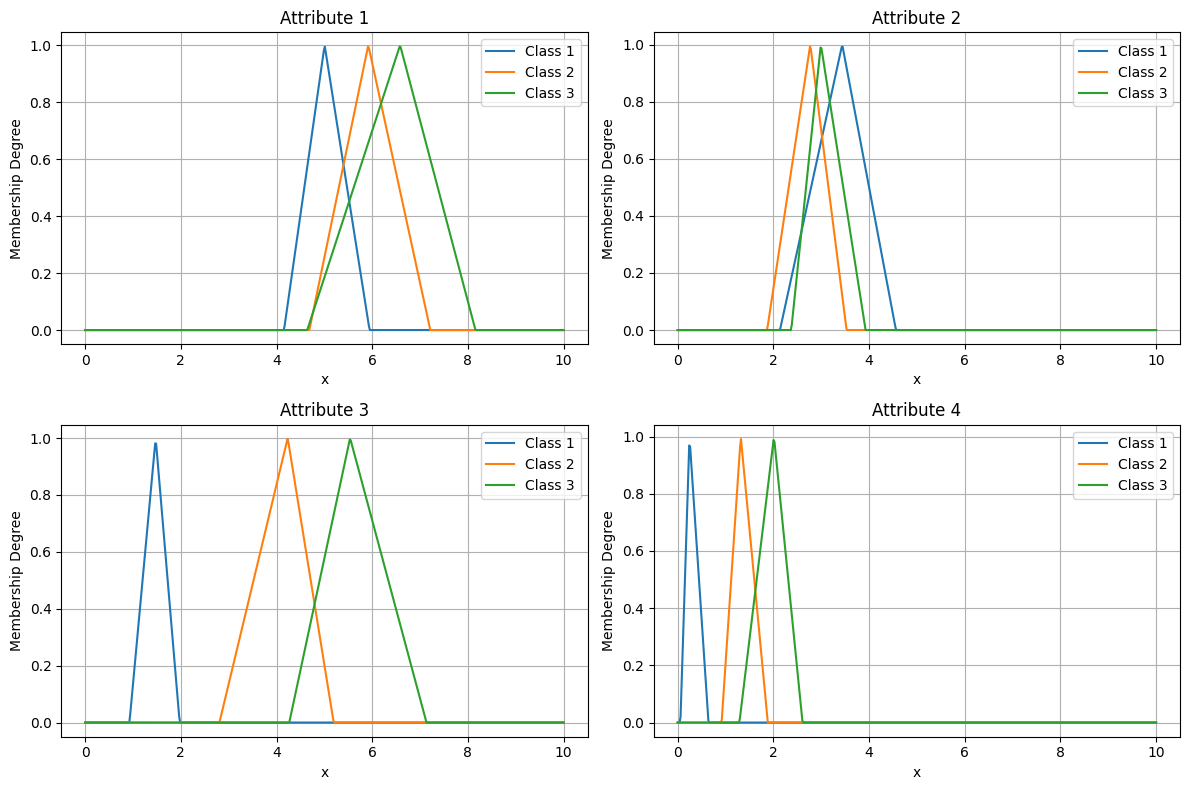

In [7]:
def plot_triangular_membership_functions(triangular_membership_functions_by_class):
    num_classes, num_attributes = triangular_membership_functions_by_class.shape
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # Assuming a reasonable range for x (e.g., [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # Two plots per row
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_triangular_membership_functions(triangular_membership_functions_by_class)

In [8]:
sample = np.random.randint(0, len(X_test))
test_sample = (X_test[sample], y_test[sample])
test_sample

(array([5.7, 2.8, 4.5, 1.3]), 1)

In [9]:

def calculate_membership_for_sample(test_sample, triangular_membership_functions_by_class):

    # test_values, true_class = test_sample  # 获取属性值和真实类别
    test_values = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # 初始化一个存储隶属度值的列表
    membership_values = []
    
    for class_idx in range(num_classes):
        class_membership_values = []
        for attr_idx in range(num_attributes):
            # 获取对应类和属性的三角隶属函数
            membership_function = triangular_membership_functions_by_class[class_idx][attr_idx]
            # 计算该属性值的隶属度
            membership_value = membership_function(test_values[attr_idx])
            class_membership_values.append(membership_value)
        membership_values.append(class_membership_values)
    
    return np.array(membership_values)


# Calculate the membership values for the test sample
membership_values = calculate_membership_for_sample(test_sample[0], triangular_membership_functions_by_class)

membership_values  # This will output the membership values for each class and attribute


array([[0.25976268, 0.50890694, 0.        , 0.        ],
       [0.8231157 , 0.96283593, 0.72256558, 0.95512385],
       [0.5452441 , 0.68907317, 0.18429855, 0.01369757]])

In [10]:
def plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample):
    test_values, true_class = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # 假设x的合理范围 (例如 [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # 两个图每行
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # 绘制测试样本的隶属度点
        for class_index in range(num_classes):
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            test_value = test_values[attr_index]  # 获取测试样本的属性值
            test_membership_value = membership_function(test_value)  # 计算测试样本的隶属度
            # 在图上标记测试样本的隶属度值
            ax.plot(test_value, test_membership_value, 'ro')  # 红点表示测试样本值
            ax.text(test_value, test_membership_value, f'{test_membership_value:.2f}', fontsize=12, color='red')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

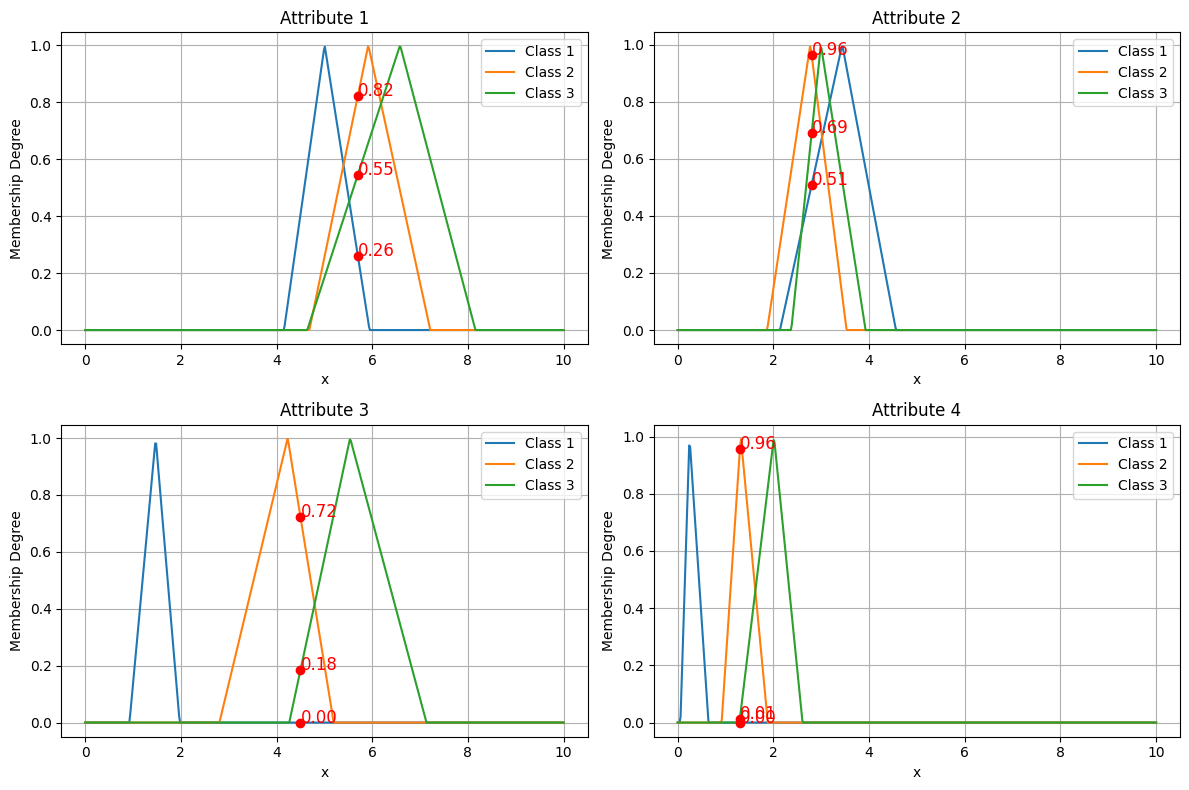

In [11]:
plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample)

In [12]:
def sort_membership(membership_values):
    sorted_indices = np.argsort(-membership_values, axis=0)  # 降序排序，使用负号实现降序
    sorted_mv = np.take_along_axis(membership_values, sorted_indices, axis=0)  # 按照索引排序后的值
    return sorted_indices, sorted_mv

In [13]:
sorted_indices, sorted_mv = sort_membership(membership_values)

In [14]:
print("\nsorted_indices\n", sorted_indices)
print("\nsorted_mv\n", sorted_mv)


sorted_indices
 [[1 1 1 1]
 [2 2 2 2]
 [0 0 0 0]]

sorted_mv
 [[0.8231157  0.96283593 0.72256558 0.95512385]
 [0.5452441  0.68907317 0.18429855 0.01369757]
 [0.25976268 0.50890694 0.         0.        ]]


In [15]:
def process_sorted_mv(sorted_mv):
    eps = 0.0001
    sorted_mv = sorted_mv + eps
    
    col_sum = np.sum(sorted_mv, axis=0)

    num_classes, num_attributes = sorted_mv.shape
    result = np.zeros((num_classes, num_attributes))
    
    result[:num_classes, :] = sorted_mv
    
    for i in range(num_attributes): 
        result[:num_classes, i] = sorted_mv[:, i] / col_sum[i] 
    
    return result

In [16]:
normalized_sorted_mv = process_sorted_mv(sorted_mv)
normalized_sorted_mv

array([[5.05529559e-01, 4.45573450e-01, 7.96620544e-01, 9.85659622e-01],
       [3.34891043e-01, 3.18896883e-01, 2.03269223e-01, 1.42371915e-02],
       [1.59579398e-01, 2.35529667e-01, 1.10233635e-04, 1.03186245e-04]])

In [17]:
np.sum(normalized_sorted_mv, axis=0)

array([1., 1., 1., 1.])

In [18]:
print("\nsorted_indices\n", sorted_indices)


sorted_indices
 [[1 1 1 1]
 [2 2 2 2]
 [0 0 0 0]]


In [19]:
def generate_bpa(normalized_sorted_mv, sorted_indices):
    dict_list = []

    num_FOD, num_attribute = normalized_sorted_mv.shape

    for i in range(num_attribute):
        dict_i = {}
        for j in range(num_FOD):
            A = tuple(sorted_indices[:j + 1, i])
            MA = normalized_sorted_mv[j, i]
            dict_i[A] = MA
        dict_list.append(dict_i)
            
    return dict_list

In [21]:
bpa_results = generate_bpa(normalized_sorted_mv, sorted_indices)
bpa_results

[{(1,): 0.5055295588550445,
  (1, 2): 0.3348910434081538,
  (1, 2, 0): 0.15957939773680166},
 {(1,): 0.44557345025954515,
  (1, 2): 0.31889688301528946,
  (1, 2, 0): 0.23552966672516543},
 {(1,): 0.796620543794929,
  (1, 2): 0.20326922256961313,
  (1, 2, 0): 0.00011023363545796961},
 {(1,): 0.985659622241208,
  (1, 2): 0.014237191513916747,
  (1, 2, 0): 0.00010318624487534038}]

In [24]:
default_fusion_order = [i for i in range(num_attributes)]
default_reliability_vector = [(1 - 0.5 * i / (num_attributes - 1)) for i in range(num_attributes)]
# default_reliability_vector = [(1 - i / (12)) for i in range(num_attributes)]
print("Default fusion order: ", default_fusion_order)
print("Default reliability vector: ", default_reliability_vector)

Default fusion order:  [0, 1, 2, 3]
Default reliability vector:  [1.0, 0.8333333333333334, 0.6666666666666667, 0.5]


In [33]:
def shuffle_by_defusion_order(data, order):
    reordered_data = [data[i] for i in order]
    return reordered_data

shuffled_bpa_results = shuffle_by_defusion_order(bpa_results, [0, 1, 2, 3])
shuffled_bpa_results

[{(1,): 0.5055295588550445,
  (1, 2): 0.3348910434081538,
  (1, 2, 0): 0.15957939773680166},
 {(1,): 0.44557345025954515,
  (1, 2): 0.31889688301528946,
  (1, 2, 0): 0.23552966672516543},
 {(1,): 0.796620543794929,
  (1, 2): 0.20326922256961313,
  (1, 2, 0): 0.00011023363545796961},
 {(1,): 0.985659622241208,
  (1, 2): 0.014237191513916747,
  (1, 2, 0): 0.00010318624487534038}]

In [34]:
def generate_all_orderings(num):
    result = []
    
    # Iterate over lengths from 1 to 3 (based on the provided examples)
    for length in range(1, 4):
        # Generate all permutations of the set {0, 1, 2} of the given length
        for perm in itertools.permutations(range(num), length):
            result.append(perm)
    
    return result

# Get the result
orderings = generate_all_orderings(3)

orderings


[(0,),
 (1,),
 (2,),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (2, 0),
 (2, 1),
 (0, 1, 2),
 (0, 2, 1),
 (1, 0, 2),
 (1, 2, 0),
 (2, 0, 1),
 (2, 1, 0)]

In [35]:
def F_RPS_reliability(x):
    result = 0
    for k in range(x + 1):
        result += math.factorial(x) / math.factorial(x - k)
    return result


def get_PMF_with_reliability(RPS_wv, reliability_vector, num_classes):
    RPS_wv_r = []

    for v, RPS_wv_j in enumerate(RPS_wv):
        RPS_wv_r_j = dict()
        
        r_v = reliability_vector[v]

        for A_tuple in generate_all_orderings(num_classes):
            MA = 0
            
            if A_tuple in RPS_wv_j:
                MA = RPS_wv_j[A_tuple]
            
            if len(A_tuple) == 1:
                MA_r = MA * r_v
            elif len(A_tuple) != 1:
                MA_r = MA * r_v + ((1 - r_v) / (F_RPS_reliability(num_classes) - num_classes - 1))
                
            #RPS_wv_r_j.add((A_tuple, MA_r))
            RPS_wv_r_j[A_tuple] = MA_r

        RPS_wv_r.append(RPS_wv_r_j)
        
    return RPS_wv_r



In [37]:
PMF_with_reliability = get_PMF_with_reliability(shuffled_bpa_results, default_reliability_vector, num_classes)
PMF_with_reliability

[{(0,): 0.0,
  (1,): 0.5055295588550445,
  (2,): 0.0,
  (0, 1): 0.0,
  (0, 2): 0.0,
  (1, 0): 0.0,
  (1, 2): 0.3348910434081538,
  (2, 0): 0.0,
  (2, 1): 0.0,
  (0, 1, 2): 0.0,
  (0, 2, 1): 0.0,
  (1, 0, 2): 0.0,
  (1, 2, 0): 0.15957939773680166,
  (2, 0, 1): 0.0,
  (2, 1, 0): 0.0},
 {(0,): 0.0,
  (1,): 0.37131120854962096,
  (2,): 0.0,
  (0, 1): 0.013888888888888886,
  (0, 2): 0.013888888888888886,
  (1, 0): 0.013888888888888886,
  (1, 2): 0.2796362914016301,
  (2, 0): 0.013888888888888886,
  (2, 1): 0.013888888888888886,
  (0, 1, 2): 0.013888888888888886,
  (0, 2, 1): 0.013888888888888886,
  (1, 0, 2): 0.013888888888888886,
  (1, 2, 0): 0.2101636111598601,
  (2, 0, 1): 0.013888888888888886,
  (2, 1, 0): 0.013888888888888886},
 {(0,): 0.0,
  (1,): 0.5310803625299527,
  (2,): 0.0,
  (0, 1): 0.027777777777777773,
  (0, 2): 0.027777777777777773,
  (1, 0): 0.027777777777777773,
  (1, 2): 0.16329059282418654,
  (2, 0): 0.027777777777777773,
  (2, 1): 0.027777777777777773,
  (0, 1, 2): 0.02

In [43]:
def right_intersection(A, B):
    """
    右正交 (RI)，即 B 中去除不在 A 中的元素
    """
    return tuple(item for item in B if item in A)


def left_intersection(A, B):
    """
    左正交 (LI)，即 A 中去除不在 B 中的元素
    """
    return tuple(item for item in A if item in B)


def calculate_KR(M1, M2):
    """
    计算右正交和的 K^R (K_R)
    """
    K_R = 0
    for B, w1 in M1.items():
        for C, w2 in M2.items():
            if right_intersection(B, C) == ():
                K_R += w1 * w2
    return K_R


def calculate_KL(M1, M2):
    """
    计算左正交和的 K^L (K_L)
    """
    K_L = 0
    for B, w1 in M1.items():
        for C, w2 in M2.items():
            if left_intersection(B, C) == ():
                K_L += w1 * w2
    return K_L


def ROS(M1, M2):
    """
    右正交和 (ROS)
    """
    K_R = calculate_KR(M1, M2)
    result = dict()

    if K_R != 1:  # 防止 K_R 为 1 时出现除以 0 的情况
        for A, w1 in M1.items():
            weight_sum = 0
            for B, w1 in M1.items():
                for C, w2 in M2.items():
                    if right_intersection(B, C) == A:
                        weight_sum += w1 * w2
            if weight_sum > 0:
                result[A] = (1 / (1 - K_R)) * weight_sum            
    return result


def LOS(M1, M2):
    """
    左正交和 (LOS)
    """
    K_L = calculate_KL(M1, M2)
    result = dict()

    if K_L != 1:  # 防止 K_L 为 1 时出现除以 0 的情况
        for A, w1 in M1.items():
            weight_sum = 0
            for B, w1 in M1.items():
                for C, w2 in M2.items():
                    if left_intersection(B, C) == A:
                        weight_sum += w1 * w2
            if weight_sum > 0:
                result[A] = (1 / (1 - K_L)) * weight_sum
    return result



# 连续右正交和
def continuous_right_orthogonal_sum(PMFs):
    """
    连续执行右正交和操作
    :param PMFs: 输入的PMF列表
    :return: 最终的右正交和结果
    """
    result = PMFs[0]
    for i in range(1, len(PMFs)):
        result = ROS(result, PMFs[i])
    return result

# 连续左正交和
def continuous_left_orthogonal_sum(PMFs):
    """
    连续执行左正交和操作
    :param PMFs: 输入的PMF列表
    :return: 最终的左正交和结果
    """
    result = PMFs[0]
    for i in range(1, len(PMFs)):
        result = LOS(result, PMFs[i])
    return result

In [44]:
pmf = continuous_left_orthogonal_sum(PMF_with_reliability)
pmf

{(1,): 0.9361819339351912,
 (2,): 0.018313169069725164,
 (1, 0): 0.002063162038963897,
 (1, 2): 0.03797244753145312,
 (2, 0): 0.002063162038963897,
 (1, 2, 0): 0.002162472055682449}

In [45]:
def calculate_OPT(pmf_data, num_classes):
    # 初始化 P_OPT, 每个类的初始概率为0
    P_OPT = {i: 0 for i in range(num_classes)}
    
    # 遍历 PMF 数据，处理每个排列事件
    for A, mass in pmf_data.items():
        if len(A) == 1:
            # 单元素事件，直接加到对应的 P_OPT 中
            theta = A[0]
            P_OPT[theta] += mass
        else:
            # 多元素事件
            last_element = A[-1]
            for theta in A:
                if theta != last_element:
                    P_OPT[theta] += mass / (len(A) - 1)
    
    return P_OPT

In [46]:
calculate_OPT(pmf, num_classes)

{0: 0, 1: 0.9772987795334496, 2: 0.021457567136530287}

In [58]:
def classify_once(x, 
                  num_classes,
                  mean_std_min_max, 
                  default_fusion_order, 
                  default_reliability_vector):

    triangular_membership_functions_by_class = get_triangular_membership_functions_list(mean_std_min_max)
    membership_values = calculate_membership_for_sample(x, triangular_membership_functions_by_class)
    sorted_indices, sorted_mv = sort_membership(membership_values)
    normalized_sorted_mv = process_sorted_mv(sorted_mv)
    bpa_results = generate_bpa(normalized_sorted_mv, sorted_indices)
    
    shuffled_bpa_results = shuffle_by_defusion_order(bpa_results, default_fusion_order)
    PMF_with_reliability = get_PMF_with_reliability(shuffled_bpa_results, default_reliability_vector, num_classes)
    
    pmf = continuous_left_orthogonal_sum(PMF_with_reliability)
    opt_dict = calculate_OPT(pmf, num_classes)
    return max(opt_dict, key=opt_dict.get)

In [59]:
sample1 = np.random.randint(0, len(X_test))
test_sample1 = (X_test[sample], y_test[sample])
test_sample1

(array([5.7, 2.8, 4.5, 1.3]), 1)

In [63]:
def test_acc(iris):
    X = iris.data  # 四个属性
    y = iris.target  # 三个类 (0, 1, 2)
    num_classes = len(np.unique(iris.target))
    num_attributes = iris.data.shape[1]
    
    default_fusion_order = [i for i in range(num_attributes)]
    default_reliability_vector = [(1 - 0.5 * i / (num_attributes - 1)) for i in range(num_attributes)]
    # 将数据集划分为训练集和测试集，乱序
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    mean_std_min_max_by_class = calculate_mean_std_min_max_by_class(X_train, y_train, num_classes)

    correct_predictions = 0
    total_samples = len(X_test)

    for test_sample, true_label in zip(X_test, y_test):
        predicted_label = classify_once(test_sample, 
                                        num_classes, 
                                        mean_std_min_max_by_class, 
                                        default_fusion_order, 
                                        default_reliability_vector)
        
        if predicted_label == true_label:
            correct_predictions += 1

    # 计算准确率
    accuracy = correct_predictions / total_samples
    return accuracy
    

In [64]:
iris = load_iris()
test_acc(iris)

0.9

In [70]:
def analyze_accuracy(iris, times=10):
    accuracies = []

    # 进行10次测试
    for _ in range(times):
        acc = test_acc(iris)  
        accuracies.append(acc)

    # 统计分析
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    print(f"{times}次测试的准确率分别是: ")
    for i in accuracies:
        print(i)
    print(f"平均准确率: {mean_acc:.4f}")
    print(f"准确率标准差: {std_acc:.4f}")
    
iris = load_iris()
analyze_accuracy(iris, times=1000)

1000次测试的准确率分别是: 
0.8666666666666667
0.8333333333333334
0.8333333333333334
0.8333333333333334
0.9333333333333333
0.7666666666666667
0.8666666666666667
0.8666666666666667
0.9
0.8666666666666667
0.9333333333333333
0.9333333333333333
0.9
0.9
0.9
0.9333333333333333
0.8
0.9
0.8
0.9
0.9
0.8333333333333334
0.9333333333333333
0.8666666666666667
0.9666666666666667
0.9333333333333333
0.9666666666666667
0.9
0.9333333333333333
0.8333333333333334
0.9
0.9333333333333333
0.7666666666666667
0.8333333333333334
0.9333333333333333
0.9
0.9666666666666667
0.9
0.9666666666666667
0.9333333333333333
0.8666666666666667
0.9
0.8
0.8666666666666667
0.9
0.8666666666666667
0.9333333333333333
0.9
0.8
0.9
0.9666666666666667
0.9
0.9
0.8666666666666667
0.8666666666666667
0.9
0.9333333333333333
0.9333333333333333
0.8666666666666667
0.8666666666666667
0.8
0.9
0.7666666666666667
0.8666666666666667
0.8
0.8666666666666667
0.9333333333333333
0.8666666666666667
0.9666666666666667
0.9666666666666667
0.8666666666666667
0.9333333